# Anchored CorEx: Topic Modeling with Minimal Domain Knowledge

In [ ]:
import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt

from corextopic import corextopic as ct
from corextopic import vis_topic# jupyter notebooks will complain matplotlib is being loaded twice

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

import pandas as pd
from sklearn.feature_extraction import text


In [2]:
data = pd.read_csv('../Data/RYANDATA_filt.csv')
data.columns = ['V0', 'topic', 'authors','title','journal','year','vol_issue','doi','abstract']
print(data.groupby('topic')['title'].nunique())

In [3]:
#split data keeping distribution
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits= 1, 
                             test_size = 0.2, 
                             random_state = 0)

for train_idx, test_idx in sss.split(data['title'],data['topic']):
    X_train, X_test = data['title'][train_idx], data['title'][test_idx]
    y_train, y_test = data['topic'][train_idx], data['topic'][test_idx]


y_train.value_counts() #same distribution as original data

GAIT/LOCOMOTION                   2547
ORTHOPAEDICS/SURGERY              2445
SPORT/EXERCISE                    2248
ORTHOPAEDICS/SPINE                1829
TISSUE/BIOMATERIAL                1693
BONE                              1565
NEURAL                            1364
COMPARATIVE                       1281
TENDON/LIGAMENT                   1241
METHODS                           1152
JOINT/CARTILAGE                   1143
DENTAL/ORAL/FACIAL                1077
MODELING                           992
CELLULAR/SUBCELLULAR               974
REHABILITATION                     941
CARDIOVASCULAR/CARDIOPULMONARY     931
ROBOTICS                           847
EVOLUTION/ANTHROPOLOGY             798
VISUAL/VESTIBULAR/EYE              622
MUSCLE                             564
VETERINARY/AGRICULTURAL            562
TRAUMA/IMPACTTESTING               552
PROSTHETICS/ORTHOTICS              443
ERGONOMICS                         402
Name: topic, dtype: int64

In [4]:
#https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
# from nltk.stem.porter import *
import numpy as np
np.random.seed(0)

# import nltk
# nltk.download('wordnet')

#tokenize, lemmatized, stemmed
stemmer = SnowballStemmer(language='english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
#             result.append(lemmatize_stemming(token))
            result.append(token)
    result = ' '.join(result)        
    return result

doc_sample = X_train[0]
print('Original document: ')
words = []
for doc in [doc_sample]:
    print(doc)
print('\nTokenized and lemmatized document: ')
print(preprocess(doc_sample),'\n')

X_train_proc = X_train.map(preprocess)

train_data = pd.DataFrame({'title':X_train_proc, 'topic':y_train})
train_data
                      
          
         

Original document: 
Proximal radius fracture morphology following axial force impact: a biomechanical evaluation of fracture patterns

Tokenized and lemmatized document: 
proximal radius fracture morphology following axial force impact biomechanical evaluation fracture patterns 



,title,topic
8793,overcoming limitations harmonic ratio reliable...,GAIT/LOCOMOTION
6411,influence different abutment designs biomechan...,DENTAL/ORAL/FACIAL
24002,content validation clinical assessment instrum...,REHABILITATION
35014,neural control adaptive neural forward models ...,ROBOTICS
16312,dual developmental origin spinal cerebrospinal...,NEURAL
21506,remplissage versus latarjet engaging hill sach...,ORTHOPAEDICS/SURGERY
3450,aquantitative image analysis cellular cytoskel...,CELLULAR/SUBCELLULAR
34341,gait trajectory rolling planning control hexap...,ROBOTICS
11238,functional properties chondrocytes articular c...,JOINT/CARTILAGE
4816,effect foot posture capacity apply free moment...,COMPARATIVE


In [5]:
#transform title data into sparse matrix
#additional stop words
stop_words = text.ENGLISH_STOP_WORDS.union(['biomechanics','biomechanical','locomotor','locomotion','study'])
#CountVectorizer
vectorizer = CountVectorizer(min_df=3,
                            max_df=0.5,
                            max_features= 20000,
                            ngram_range=(1,3),
                            strip_accents='unicode',
                            lowercase=True,
                            analyzer='word',
                            stop_words=stop_words,
                            token_pattern= '[a-zA-Z-0-9]{3,}',
                           )
doc_word = vectorizer.fit_transform(train_data['title'])
doc_word = ss.csr_matrix(doc_word)
doc_word.shape # n_docs x m_words


(28213, 20000)

In [6]:
#get common words for each topic
n_top_topics = 3
title_subset = []
top_words = []
freq_list = []
words_freq = []
for i in train_data.groupby('topic'):
    title_subset.append(i)
for a in title_subset:  
    a # all titles in a given topic
    bag_of_words = vectorizer.transform(a[1]['title'])
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    words_freq = words_freq[:n_top_topics]
    for item in list(zip(*words_freq))[0]:
        freq_list.append(item)
#split list
freq_list = [freq_list[i:i + n_top_topics] for i in range(0, len(freq_list), n_top_topics)]

In [114]:
train_data.groupby('topic')['topic'].unique()

topic
BONE                                                        [BONE]
CARDIOVASCULAR/CARDIOPULMONARY    [CARDIOVASCULAR/CARDIOPULMONARY]
CELLULAR/SUBCELLULAR                        [CELLULAR/SUBCELLULAR]
COMPARATIVE                                          [COMPARATIVE]
DENTAL/ORAL/FACIAL                            [DENTAL/ORAL/FACIAL]
ERGONOMICS                                            [ERGONOMICS]
EVOLUTION/ANTHROPOLOGY                    [EVOLUTION/ANTHROPOLOGY]
GAIT/LOCOMOTION                                  [GAIT/LOCOMOTION]
JOINT/CARTILAGE                                  [JOINT/CARTILAGE]
METHODS                                                  [METHODS]
MODELING                                                [MODELING]
MUSCLE                                                    [MUSCLE]
NEURAL                                                    [NEURAL]
ORTHOPAEDICS/SPINE                            [ORTHOPAEDICS/SPINE]
ORTHOPAEDICS/SURGERY                        [ORTHOPAEDIC

In [7]:
anchor_list = pd.DataFrame({'top_words':freq_list})
anchor_list.iloc[0]['top_words'] #will use this to anchor model later. 
len(anchor_list)

24

In [8]:
# Get words that label the columns (needed to extract readable topics and make anchoring easier)
words = list(np.asarray(vectorizer.get_feature_names()))
len(words)

20000

## CorEx Topic Model

The main parameters of the CorEx topic model are:
+ **`n_hidden`**: number of topics ("hidden" as in "hidden latent topics")
+ **`words`**: words that label the columns of the doc-word matrix (optional)
+ **`docs`**: document labels that label the rows of the doc-word matrix (optional)
+ **`max_iter`**: number of iterations to run through the update equations (optional, defaults to 200)
+ **`verbose`**:  if `verbose=1`, then CorEx will print the topic TCs with each iteration
+ **`seed`**:     random number seed to use for model initialization (optional)

We'll train a topic model with 50 topics. (This will take a few minutes.)

In [9]:
# Train the CorEx topic model with 24 topics
n_topics = len(anchor_list)
topic_model = ct.Corex(n_hidden=n_topics, 
                       words=words, 
                       max_iter=100, 
                       verbose=False, 
                       seed=1, 
                       docs = train_data['title'])
topic_model.fit(doc_word, words=words,);
print('model fit with',n_topics,'topics')

model fit with 24 topics


## CorEx Output

In [11]:
# Print a single topic from CorEx topic model
topic_model.get_topics(topic=0, n_words=10)

[('ligament', 0.08626370900902366),
 ('cruciate', 0.07641463212816249),
 ('cruciate ligament', 0.07422582307047186),
 ('anterior', 0.06975680980515406),
 ('anterior cruciate', 0.06533307853773158),
 ('anterior cruciate ligament', 0.06509079934540464),
 ('fixation', 0.05300261188729524),
 ('ligament reconstruction', 0.044280245015334674),
 ('reconstruction', 0.043800742671592396),
 ('cruciate ligament reconstruction', 0.03535111360783326)]

The topic words are those with the highest *mutual information* with the topic, rather than those with highest probability within the topic as in LDA. The mutual information with the topic is the number reported in each tuple. Theoretically, mutual information is always positive. If the CorEx output returns a negative mutual information from **`get_topics()`**, then the absolute value of that quantity is the mutual information between the topic and the *absence* of that word.

If the column labels have not been specified through **`words`**, then the code will return the column indices for the top words in each topic.

We can also retrieve all of the topics at once if we would like.

In [12]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: ligament,cruciate,cruciate ligament,anterior,anterior cruciate,anterior cruciate ligament,fixation,ligament reconstruction,reconstruction,cruciate ligament reconstruction
1: finite,element,finite element,element analysis,finite element analysis,analysis,randomized,trial,randomized controlled,element model
2: gait,walking,lower,limb,kinematics,knee,lower limb,running,ankle,training
3: lumbar,spine,cervical,disc,fusion,intervertebral,cervical spine,lumbar spine,interbody,intervertebral disc
4: fractures,systematic review,systematic,review,distal,plate,meta,meta analysis,risk factors,intramedullary
5: injury,cord injury,spinal cord injury,recovery,traumatic,brain injury,resonance imaging,magnetic resonance imaging,traumatic brain,functional recovery
6: osteoarthritis,term,pain,adults,knee osteoarthritis,long term,older,children,healthy,cross
7: cord,spinal cord,spinal,rats,healing,pedicle,pedicle screw,fracture healing,marrow,bone marrow
8: arthroplasty,total,stem,extremity,stem cells,

The first topic for the newsgroup data tends to be less coherent than expected because of encodings and other oddities in the newsgroups data.  

We can also get the column indices instead of the column labels if necessary.

In [13]:
topic_model.get_topics(topic=5, n_words=10, print_words=False)

[(9305, 0.13689134948094794),
 (3800, 0.07101714665127068),
 (16268, 0.07073561037584167),
 (14062, 0.025800825099922094),
 (18557, 0.01581258637595512),
 (2446, 0.010316702112436453),
 (14517, 0.010056702515392367),
 (10631, 0.010056702515392367),
 (18558, 0.00953695848495123),
 (7904, 0.009536956668611136)]

If we need to directly access the topic assignments for each word, they can be accessed through **`cluster`**.

In [14]:
print(topic_model.clusters)
print(topic_model.clusters.shape) # m_words

[11 11 11 ...  4 14  1]
(20000,)


### Document Labels

As with the topic words, the most probable documents per topic can also be easily accessed. Documents are sorted according to log probabilities which is why the highest probability documents have a score of 0 ($e^0 = 1$) and other documents have negative scores (for example, $e^{-0.5} \approx 0.6$).

In [15]:
# Print a single topic from CorEx topic model
topic_n = 0
indx = topic_model.get_top_docs(topic=topic_n, n_docs=10, sort_by='log_prob')
print("\nPapers for topic",topic_n)
for i in indx:
    print(i[0],train_data['title'].iloc[i[0]],'\n')

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices

Papers for topic 0
3989 biomechanical deficiencies women semitendinosus gracilis anterior cruciate ligament reconstruction drop jumps 

9407 prevalence classification injuries anterolateral complex acute anterior cruciate ligament tears 

19204 assessing lower extremity coordination coordination variability individuals anterior cruciate ligament reconstruction walking 

19206 quantification role tibial posterior slope knee joint mechanics force simulated gait 

19212 biomechanical evaluation double krackow sutures versus loop pulley suture canine gastrocnemius tendon avulsion model 

9401 motor control strategies double squat following anterior cruciate ligament rupture reconstruction observational study 

19233 independent suture tape reinforcement small standard diameter grafts anterior cruciate ligament reconstruction biomechanical construct model 

19261 effect fatty infiltration quality tendon bone hea

CorEx is a *discriminative* model, whereas LDA is a *generative* model. This means that while LDA outputs a probability distribution over each document, CorEx instead estimates the probability a document belongs to a topic given that document's words. As a result, the probabilities across topics for a given document do not have to add up to 1. The estimated probabilities of topics for each document can be accessed through **`log_p_y_given_x`** or **`p_y_given_x`**.

In [16]:
print(topic_model.p_y_given_x.shape) # n_docs x k_topics

(28213, 24)


We can also use a softmax to make a binary determination of which documents belong to each topic. These softmax labels can be accessed through **`labels`**.

In [17]:
print(topic_model.labels.shape) # n_docs x k_topics

(28213, 24)


In [18]:
corex_pred_data = pd.DataFrame(topic_model.p_y_given_x)


Since CorEx does not prescribe a probability distribution of topics over each document, this means that a document could possibly belong to no topics (all 0's across topics in **`labels`**) or all topics (all 1's across topics in **`labels`**).

## Total Correlation and Model Selection

### Overall TC

Total correlation is the measure which CorEx maximize when constructing the topic model. It can be accessed through **`tc`** and is reported in nats.

In [19]:
print(topic_model.tc)

print(topic_model.tc/n_topics)

10.11698782455846
0.4215411593566025


**Model selection:** CorEx starts its algorithm with a random initialization, and so different runs can result in different topic models. One way of finding a better topic model is to restart the CorEx algorithm several times and take the run that has the highest TC value (i.e. the run that produces topics that are most informative about the documents).

### Topic TC

The overall total correlation is the sum of the total correlation per each topic. These can be accessed through **`tcs`**. For an unsupervised CorEx topic model, the topics are always sorted from high to low according to their TC. For an anchored CorEx topic model, the topics are not sorted, and are outputted such that the anchored topics come first.

In [20]:
topic_model.tcs.shape# k_topics

(24,)

In [21]:
print(np.sum(topic_model.tcs))
print(topic_model.tc)

10.11698782455846
10.11698782455846


**Selecting number of topics:** one way to choose the number of topics is to observe the distribution of TCs for each topic to see how much each additional topic contributes to the overall TC. We should keep adding topics until additional topics do not significantly contribute to the overall TC. This is similar to choosing a cutoff eigenvalue when doing topic modeling via LSA.

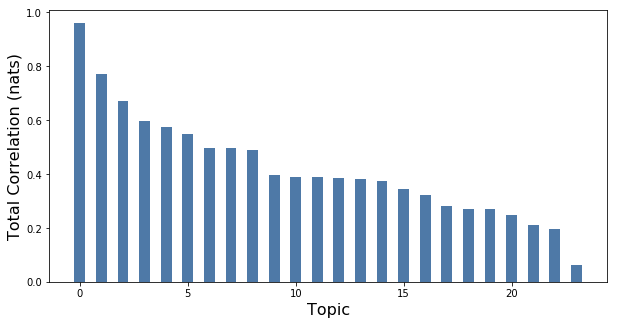

In [22]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

We see the first topic is much more informative than the other topics. Given that we suspect that this topic is picking up on image encodings (as given by "dsl" and "n3jxp" in the topic) and other boilerplate text (as given by the high TC and lack of coherence of the rest of the topic), we could consider doing additional investigation and preprocessing to help ensure that the CorEx topic model does not pick up on these patterns which are not insightful.

### Pointwise Document TC

We can decompose total correlation further. The topic correlation is the average of the pointwise total correlations for each individual document. The pointwise total correlations can be accessed through **`log_z`**.

In [23]:
topic_model.log_z.shape # n_docs x k_topics

(28213, 24)

In [24]:
print(np.mean(topic_model.log_z, axis=0))
print(topic_model.tcs)

[0.95931342 0.77065569 0.67148248 0.59464833 0.57400126 0.54768678
 0.49712199 0.49567791 0.48846456 0.39734458 0.38899748 0.38663926
 0.3851079  0.38263739 0.37374132 0.34275251 0.32084882 0.28259021
 0.27152634 0.27088085 0.24935536 0.20892129 0.19574291 0.0608492 ]
[0.95931342 0.77065569 0.67148248 0.59464833 0.57400126 0.54768678
 0.49712199 0.49567791 0.48846456 0.39734458 0.38899748 0.38663926
 0.3851079  0.38263739 0.37374132 0.34275251 0.32084882 0.28259021
 0.27152634 0.27088085 0.24935536 0.20892129 0.19574291 0.0608492 ]


The pointwise total correlations in **`log_z`** represent the correlations within an individual document explained by a particular topic. These correlations have been used to measure how "surprising" documents are with respect to given topics (see references below).

## Hierarchical Topic Models

The **`labels`** attribute gives the binary topic expressions for each document and each topic. We can use this output as input to another CorEx topic model to get latent representations of the topics themselves. This yields a hierarchical CorEx topic model. Like the first layer of the topic model, one can determine the number of latent variables to add in higher layers through examination of the topic TCs.

In [ ]:
# # Train a second layer to the topic model
# tm_layer2 = ct.Corex(n_hidden=10)
# tm_layer2.fit(topic_model.labels);

# # Train a third layer to the topic model
# tm_layer3 = ct.Corex(n_hidden=1)
# tm_layer3.fit(tm_layer2.labels);

If you have `graphviz` installed, then you can output visualizations of the hierarchial topic model to your current working directory. One can also create custom visualizations of the hierarchy by properly making use of the **`labels`** attribute of each layer.

In [ ]:
# # no unicode??
# vis_hierarchy([topic_model, tm_layer2, tm_layer3], column_label=words, max_edges=200, prefix='topic-model-example')

# from graphviz import Source
# path = 'topic-model-example/graphs/graph_prune_200.dot'
# s = Source.from_file(path)
# s.view()

## Anchoring for Semi-Supervised Topic Modeling

Anchored CorEx is an extension of CorEx that allows the "anchoring" of words to topics. When anchoring a word to a topic, CorEx is trying to maximize the mutual information between that word and the anchored topic. So, anchoring provides a way to guide the topic model towards specific subsets of words that the user would like to explore.  

The anchoring mechanism is flexible, and so there are many possibilities of anchoring. We explored the following types of anchoring in our TACL paper:

1. Anchoring a single set of words to a single topic. This can help promote a topic that did not naturally emerge when running an unsupervised instance of the CorEx topic model. For example, one might anchor words like "snow," "cold," and "avalanche" to a topic if one suspects there should be a snow avalanche topic within a set of disaster relief articles.

2. Anchoring single sets of words to multiple topics. This can help find different aspects of a topic that may be discussed in several different contexts. For example, one might anchor "protest" to three topics and "riot" to three other topics to understand different framings that arise from tweets about political protests.

3. Anchoring different sets of words to multiple topics. This can help enforce topic separability if there appear to be chimera topics. For example, one might anchor "mountain," "Bernese," and "dog" to one topic and "mountain," "rocky," and "colorado" to another topic to help separate topics that merge discussion of Bernese Mountain Dogs and the Rocky Mountains.


We'll demonstrate how to anchor words to the the CorEx topic model and how to develop other anchoring strategies.

In [35]:
anchor_list_list = anchor_list.to_dict('list')
# anchor_list.iloc[0]['top_words']
anchor_words = anchor_list['top_words']
# Anchor one word to the first topic
anchor_words


0                   [bone, model, fracture]
1               [aortic, properties, valve]
2                 [cell, cells, mechanical]
3         [performance, morphology, muscle]
4               [analysis, implant, finite]
5          [work, effects, musculoskeletal]
6     [evolution, implications, morphology]
7                     [gait, walking, knee]
8                  [knee, cartilage, joint]
9                 [analysis, based, method]
10                 [model, finite, element]
11      [muscle, skeletal, skeletal muscle]
12              [spinal, cord, spinal cord]
13                [lumbar, spine, cervical]
14        [fixation, fractures, comparison]
15           [foot, prosthesis, prosthetic]
16                 [training, spinal, gait]
17                 [robot, control, robots]
18          [performance, effects, players]
19             [ligament, tendon, cruciate]
20         [tissue, properties, mechanical]
21                   [impact, head, injury]
22                  [canine, dai

In [38]:

anchored_topic_model = ct.Corex(n_hidden=n_topics, seed=2) 
anchored_topic_model.fit(doc_word, 
                         words=words, 
                         anchors=anchor_words, 
                         anchor_strength=5);
print('anchored model fit')

anchored model fit


New topic: model,bone,fracture
[1.744 1.116 1.329 0.926 1.702 0.968 0.744 1.433 1.592 1.316 2.033 1.074
 2.216 1.287 1.786 0.754 1.429 0.919 1.063 2.105 1.298 1.146 0.528 1.039]
31.54933232556265


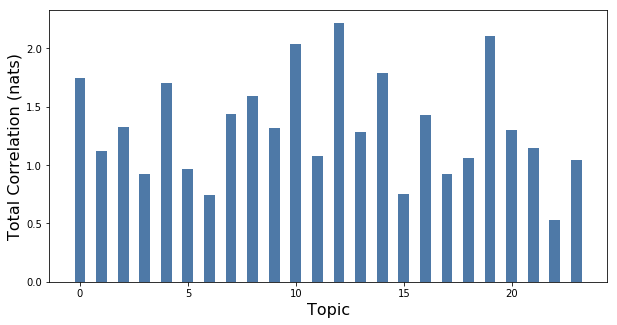

In [39]:
topic_words,_ = zip(*anchored_topic_model.get_topics(topic=0))
print('New topic: ' + ','.join(topic_words[0:3]))
print(np.round(anchored_topic_model.tcs,3))
plt.figure(figsize=(10,5))
plt.bar(range(anchored_topic_model.tcs.shape[0]), anchored_topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);
print(anchored_topic_model.tc)

In [ ]:
from sklearn.externals import joblib
joblib.dump(anchored_topic_model, '../Models/LDA/anchored_topic_model.pkl')
joblib.dump(vectorizer, '../Models/LDA/anchored_topic_vectorizer.pkl')

print ("Model/Vectorizer Saved")

We can anchor multiple groups of words to multiple topics as well.

In [247]:
n_docs = 1
topic_titles = ['' for x in range(n_topics)]
topic_names = ['' for x in range(n_topics)]
topic_list = train_data.groupby('topic')['topic'].unique().index
topic_model_top_papers = pd.DataFrame([])

for topic_n in range(n_topics):
    new_titles = []
    topic_name = []
    indx = anchored_topic_model.get_top_docs(topic=topic_n, n_docs=n_docs, sort_by='log_prob')
    for item in list(zip(*indx))[0]:
        new_titles.append(train_data['title'].iloc[item])
        topic_name.append(topic_list[topic_n])
        temp_df = pd.DataFrame({'title':new_titles, 'topic':topic_name})
#         print(item)    
#     print("\nPapers for topic",topic_n)
#     for i in indx:
#         new_titles.append(train_data['title'].iloc[i[0]])
    print(topic_n)
    topic_titles[topic_n] = new_titles
    topic_names[topic_n] = topic_name
    if topic == 0:
        topic_model_top_papers = topic_model_top_papers.append(temp_df, ignore_index=True)
    else:
        topic_model_top_papers = topic_model_top_papers.append(temp_df, ignore_index=True)
#     topic_model_top_papers.append(temp_df, ignore_index = True)

#split list
# topic_titles = [topic_titles[i:i + n_docs] for i in range(0, len(topic_titles), n_docs)]
# topic_model_top_papers = pd.DataFrame({'title':topic_titles, 'topic':topic_names})
# topic_model_top_papers = topic_model_top_papers.transpose()
temp_df

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
0
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
1
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
2
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
3
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
4
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
5
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
6
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
7
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
8
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
9
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
10
NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
11
NOTE: 'docs' not provided 

,title,topic
0,biological biomechanical properties meniscal s...,VISUAL/VESTIBULAR/EYE


In [250]:
pd.set_option('max_colwidth',-1)
topic_model_top_papers #i don't think this is totally right.

,title,topic
0,effect static bone strain implant stability bone remodeling,BONE
1,layer region specific material ascending thoracic aortic aneurysms microstructure based models,CARDIOVASCULAR/CARDIOPULMONARY
2,bone marrow derived mesenchymal stem cells obtained arthroscopic rotator cuff repair surgery potential tendon cell differentiation treatment insulin,CELLULAR/SUBCELLULAR
3,elastic ankle muscle tendon interactions adjusted produce acceleration walking humans,COMPARATIVE
4,implant material design alter construct stiffness distal femur locking plate fixation pilot study,DENTAL/ORAL/FACIAL
5,computational model effects intraluminal thrombus enlargement abdominal aortic aneurysms,ERGONOMICS
6,morphology humeral insertion supraspinatus infraspinatus tendons application rotator cuff repair,EVOLUTION/ANTHROPOLOGY
7,overcoming limitations harmonic ratio reliable assessment gait symmetry,GAIT/LOCOMOTION
8,coronal oblique imaging knee increase radiologists confidence diagnosing posterior root meniscal tears clinical radiology,JOINT/CARTILAGE
9,identification stair climbing ability levels community dwelling older adults based geometric mean stair ascent descent speed gemss classifier,METHODS


In [205]:
tops = train_data.groupby('topic')['topic'].unique().index
tops.name = None
topic_model_top_papers.columns = tops
topic_model_top_papers

,BONE,CARDIOVASCULAR/CARDIOPULMONARY,CELLULAR/SUBCELLULAR,COMPARATIVE,DENTAL/ORAL/FACIAL,ERGONOMICS,EVOLUTION/ANTHROPOLOGY,GAIT/LOCOMOTION,JOINT/CARTILAGE,METHODS,...,ORTHOPAEDICS/SURGERY,PROSTHETICS/ORTHOTICS,REHABILITATION,ROBOTICS,SPORT/EXERCISE,TENDON/LIGAMENT,TISSUE/BIOMATERIAL,TRAUMA/IMPACTTESTING,VETERINARY/AGRICULTURAL,VISUAL/VESTIBULAR/EYE
0,effect static bone strain implant stability bo...,layer region specific material ascending thora...,bone marrow derived mesenchymal stem cells obt...,elastic ankle muscle tendon interactions adjus...,implant material design alter construct stiffn...,computational model effects intraluminal throm...,morphology humeral insertion supraspinatus inf...,overcoming limitations harmonic ratio reliable...,coronal oblique imaging knee increase radiolog...,identification stair climbing ability levels c...,...,comparison multiple linear regression artifici...,muscle force distribution lower limbs walking ...,overcoming limitations harmonic ratio reliable...,multicontact locomotion transfemoral prosthese...,effects functional electrical stimulation gait...,contribution antirotational pins intact fibula...,mechanical energetic consequences reduced ankl...,investigation relationship facial injuries tra...,evaluation ultrasonography measuring solar sof...,biological biomechanical properties meniscal s...
1,predicting bending properties long bones insig...,regional variations nonlinearity anisotropy bo...,heterogeneous mechanical response human brain ...,locomotory pearlfish carapus acus morphologica...,biomechanical evaluation sagittal maxillary in...,immediate effects real time feedback jump land...,tail architecture function cebupithecia sarmie...,enhanced somatosensory feedback reduces prefro...,mild length discrepancy affects lower limbs pe...,adjacent segment disease posterior lumbar inte...,...,comparison techniques achieving planned correc...,impaired foot force direction regulation postu...,proprioceptors preferentially modulate reflexe...,obstacle surpassing posture control stair clim...,mechanical models sandfish locomotion reveal p...,collagen implants experimental tendon injury r...,experimental numerical study mechanical behavi...,impact obstacles navigation precision reaction...,effect week active play intervention fundament...,plantar pressure differences nordic walking te...
2,correlation mineralization mechanical strength...,simulations transcatheter aortic valve implant...,design comparison mobile mechanical testing de...,activity claw retractor muscle stick insects w...,knee function anterior cruciate ligament recon...,synergistic effects bdnf rehabilitative traini...,ontogeny talo crural appositional articular mo...,superficial medial collateral ligament primary...,modelling analysis biomechanical dynamic chara...,novel method synchronizing motion capture data...,...,radiographic feasibility study cortical bone t...,contributions lower extremity kinematics trunk...,multicenter clinical randomized controlled tri...,step contributions stance muscle spindle affer...,technical factors explain competition performa...,influence acute chronic streptozotocin induced...,difference subchondral cancellous bone postmen...,high intensity locomotor exercise increases br...,biaxial mechanical testing posterior sclera hi...,evaluation mechanical properties fixed bone ce...
3,thorough debridement fibular allograft impacti...,fluid structure interaction analysis abdominal...,deriving vascular smooth muscle cells mesenchy...,differences glenohumeral joint morphology pati...,reflection ultrasonic wave bone implant interf...,effects spinal cord electrical stimulation pat...,height skeletal morphology relation modern lif...,evaluation mechanisms underlying influence ste...,single trial estimation quasi static joint mec...,ankle foot power gait analysis implications sc...,...,influence rotation femoral offset following sh...,lower limb driven energy harvester modeling de...,postural instability gait

**Choosing anchor strength:** the anchor strength controls how much weight CorEx puts towards maximizing the mutual information between the anchor words and their respective topics. Anchor strength should always be set at a value *greater than* 1, since setting anchor strength between 0 and 1 only recovers the unsupervised CorEx objective. Empirically, setting anchor strength from 1.5-3 seems to nudge the topic model towards the anchor words. Setting anchor strength greater than 5 is strongly enforcing that the CorEx topic model find a topic associated with the anchor words.

We encourage users to experiment with the anchor strength and determine what values are best for their needs.

## Further Reading

Our TACL paper details the theory of the CorEx topic model, its sparsity optimization, anchoring via the information bottleneck, comparisons to LDA, and anchoring experiments. The two papers from Greg Ver Steeg and Aram Galstyan develop the CorEx theory in general and provide further motivation and details of the underlying CorEx mechanisms. Hodas et al. demonstrated early CorEx topic model results and investigated an application of pointwise total correlations to quantify "surprising" documents.

1. [Anchored Correlation Explanation: Topic Modeling with Minimal Domain Knowledge](https://www.transacl.org/ojs/index.php/tacl/article/view/1244), Gallagher et al., TACL 2017.

2. [Discovering Structure in High-Dimensional Data Through Correlation Explanation](https://arxiv.org/abs/1406.1222), Ver Steeg and Galstyan, NIPS 2014. 

3. [Maximally Informative Hierarchical Representions of High-Dimensional Data](https://arxiv.org/abs/1410.7404), Ver Steeg and Galstyan, AISTATS 2015.

4. [Disentangling the Lexicons of Disaster Response in Twitter](https://dl.acm.org/citation.cfm?id=2741728), Hodas et al., WWW 2015.